In [1]:
# Loading the test files
import pickle
import librosa
import numpy as np
import matplotlib.pyplot as plt
from keras import Input
import seaborn as sns
from keras.optimizers import Adam
from keras.layers import (Dense, dot, Dropout, LSTM, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, GlobalAveragePooling1D,
                        Lambda, Reshape, Conv1D, MaxPooling1D)
from keras.models import Model, Sequential
from keras.losses import binary_crossentropy
import keras.backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from itertools import combinations
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Problem 1: Siamese Network

In this task, we are required to implement a Siamese Network to perform Speaker Disambiguation, that is, given a pair of speech signals, the network needs to determine if they belong to the same speaker or different ones.

In [2]:
# Loading the training files
with open('hw4_trs.pkl', 'rb') as file:
    data = pickle.load(file)

In [3]:
# Loading test files
with open('hw4_tes.pkl', 'rb') as file:
    test = pickle.load(file)

In [4]:
# STFT Transformation on train files
train_data = []
for i in range(len(data)):
    train_data.append(librosa.stft(data[i], n_fft=1024, hop_length=512))
train_data = np.stack(train_data)

In [5]:
# STFT Transformation on test files
test_data = []
for i in range(len(test)):
    test_data.append(librosa.stft(test[i], n_fft=1024, hop_length=512))
test_data = np.stack(test_data)

In [6]:
# Obtaining the magnitude of train files
train_data_abs = np.transpose(np.abs(train_data), axes = (0, 2, 1))
train_data_abs.shape

(500, 32, 513)

In [7]:
# Obtaining the magnitude of test files
test_data_abs = np.transpose(np.abs(test_data), axes = (0, 2, 1))
test_data_abs.shape

(200, 45, 513)

The generators defined below are used by the model to get training, test and validation data for training/testing. The generators have a tree like structure. The parent generator, named data_generator, generates all the possible combinations of a speakers utterances as positive examples. It generates equal number of negative examples by sampling with replacement from current speaker's utterances and without replacement from all the other utterances from various other speakers. These positive and negative example pairs are concatenated to form a single numpy array which is returned by the generator, along with target, when it is called. data_generator is used by train_valid_generator to produce training set or validation set based on the value of flag variable valid. train_valid_generator obtains speech pairs and corresponding target values from data_genrator and splits it into training and test set. Every time the split is made the same way so that I can correctly divide a batch into non-overlapping training and validation set. The train/valid batch is then shuffled to induce randomness and returned by the generator. The test_generator works the same way but without the splitting operation.

In [8]:
# Function that produces positive and negative example pairs along with the targets that is to be used by the network
def data_generator(data):
    np.random.seed(1024)
    i = 0
    while True:
        positive_pairs = np.array(list(combinations(data[i:i+10], 2)))
        negative_p_part = data[np.random.choice(np.arange(i, i+10), size = len(positive_pairs))]
        negative_n_part = data[np.random.choice([ind for ind in range(len(data)) if ind not in np.arange(i, i+10)], size = len(positive_pairs))]
        negative_pairs = np.array(list(zip(negative_p_part, negative_n_part)))
        target = np.concatenate((np.ones(45), np.zeros(45)))
        batch = np.concatenate((positive_pairs, negative_pairs))
        i += 10
        if i>= len(data):
            i = 0
        yield batch, target

In [9]:
# Generator used to generate minibatches for training and validation of the model
def train_valid_generator(data, valid = False):
    gen = data_generator(data)
    while True:
        sb, t = next(gen)
        tb, vb, tt, vt = train_test_split(sb, t, test_size = 0.2, random_state= 25, stratify = t)
        if not valid:
            te = list(zip(tb, tt))
            np.random.shuffle(te)
            tb, tt = zip(*te)
            tb = np.transpose(tb, (1,0,2,3))
            yield [tb[0], tb[1]], np.array(tt)
        else:
            ve = list(zip(vb, vt))
            np.random.shuffle(ve)
            vb, vt = zip(*ve)
            vb = np.transpose(vb, (1,0,2,3))
            yield [vb[0], vb[1]], np.array(vt)

In [10]:
# Generator used to generate minibatches from test data
def test_generator(data):
    gen = data_generator(data)
    while True:
        test_batch, test_target = next(gen)
        test_datapoint = list(zip(test_batch, test_target))
        np.random.shuffle(test_datapoint)
        test_batch, test_target = zip(*test_datapoint)
        test_batch = np.transpose(test_batch, (1,0,2,3))
        yield [test_batch[0], test_batch[1]], np.array(test_target)

For the task of speaker disambiguation, I have used a siamese network made up of LSTM cells. The reason for choosing LSTM cells is to allow the network handle varying length speech signals. The network produces a 100 dimensional code for each pair of speech signals given as input to the network. These code vectors are then joined using dot product to produce a single value and lastly, sigmoid operation is performed on this value to produce the binary outputs: 0 - if the two speech signals are from same speaker or 1 - if the two speech signals are from different speakers.

In [12]:
# Defining layers used in the network
# 70% test accuracy with 513, 256, 128 LSTM, lr = 0.0001, dense = 1024, 512, 100
shared_lstm1 = LSTM(513, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.5)
shared_lstm2 = LSTM(256, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.5)
shared_lstm3 = LSTM(128, return_sequences = False, dropout = 0.2, recurrent_dropout = 0.5)
shared_fc1 = Dense(1024, activation = 'relu', kernel_initializer='he_normal')
shared_drop1 = Dropout(0.5)
shared_fc2 = Dense(512, activation = 'relu', kernel_initializer='he_normal')
shared_drop2 = Dropout(0.5)
shared_fc3 = Dense(100, activation='relu', kernel_initializer='he_normal')
last_layer = Dense(1, activation = 'relu', kernel_initializer = 'he_normal')

# Shared Model
input_tensor = Input(shape = (None, 513))
x = shared_lstm1(input_tensor)
x = shared_lstm2(x)
x = shared_lstm3(x)
x = shared_fc1(x)
# x = shared_drop1(x)
x = shared_fc2(x)
# x = shared_drop2(x)
output_tensor = shared_fc3(x)
model = Model(input_tensor, output_tensor)

# Defining different streams in model
stream_1_input = Input(shape=(None, 513))
stream_2_input = Input(shape=(None, 513))
stream_1_output = model(stream_1_input)
stream_2_output = model(stream_2_input)

# Combining the two embedding, produced for each signal by different streams, by taking the dot product
combined = dot([stream_1_output, stream_2_output], axes = 1)
output = last_layer(combined)

# Connecting the inputs and output to form the siamese network
siamese = Model(inputs = [stream_1_input, stream_2_input], outputs = output)

In [14]:
# Shared base summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 513)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 513)         2107404   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 256)         788480    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               51300     
Total para

In [15]:
# Siamese Summary
print(siamese.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 513)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None, 513)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 100)          3801200     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot)                     (None, 1)            0           model_1[1][0]                    
          

In [16]:
# Compiling Model
siamese.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 0.0001), metrics = ['accuracy'])

In [17]:
# Callbacks used to stop training model when it has stopped improving
callback_list = [EarlyStopping(monitor = 'val_loss', patience=20, restore_best_weights=True),
                ModelCheckpoint(filepath='siamese.h5', save_best_only=True, monitor='val_loss')]

In [18]:
# Training Model
history = siamese.fit_generator(train_valid_generator(train_data_abs), steps_per_epoch = 50, epochs = 500, \
                                validation_data=train_valid_generator(train_data_abs, valid = True), validation_steps=50, \
                                callbacks=callback_list)

Epoch 1/500
50/50 [==============================] - 21s 428ms/step - loss: 0.8702 - acc: 0.5119 - val_loss: 0.7847 - val_acc: 0.5056
Epoch 2/500
50/50 [==============================] - 15s 295ms/step - loss: 0.7549 - acc: 0.5164 - val_loss: 0.7560 - val_acc: 0.5122
Epoch 3/500
50/50 [==============================] - 15s 298ms/step - loss: 0.7365 - acc: 0.5128 - val_loss: 0.7229 - val_acc: 0.5233
Epoch 4/500
50/50 [==============================] - 15s 293ms/step - loss: 0.7201 - acc: 0.5075 - val_loss: 0.7505 - val_acc: 0.5078
Epoch 5/500
50/50 [==============================] - 15s 301ms/step - loss: 0.7237 - acc: 0.5181 - val_loss: 0.7119 - val_acc: 0.5400
Epoch 6/500
50/50 [==============================] - 15s 310ms/step - loss: 0.7212 - acc: 0.5167 - val_loss: 0.7005 - val_acc: 0.5500
Epoch 7/500
50/50 [==============================] - 15s 308ms/step - loss: 0.7078 - acc: 0.5242 - val_loss: 0.7001 - val_acc: 0.5356
Epoch 8/500
50/50 [==============================] - 16s 316ms

In [19]:
# Evaluating the model on held-out test data
score = siamese.evaluate_generator(test_generator(test_data_abs), steps=20)
print('Accuracy:', round(score[1]*100, 2))

Accuracy: 77.83


As we can see, the accuracy of this network on held-out test data is fairly high. The network is working well but there's still some room for improvement. Since, I am using LSTM cells, the network is a little slow to train but it doesn't take much time(max. 5 min).

In [ ]:
# Garbage Disposal
del model, siamese

## Problem 2: Variational Auto Encoder

In this task we are required to implement a variational auto encoder on a subset of images of digit '7' from MNIST handwritten digits dataset.

In [2]:
# Loading the training files
with open('hw4_tr7.pkl', 'rb') as file:
    train_data = pickle.load(file)

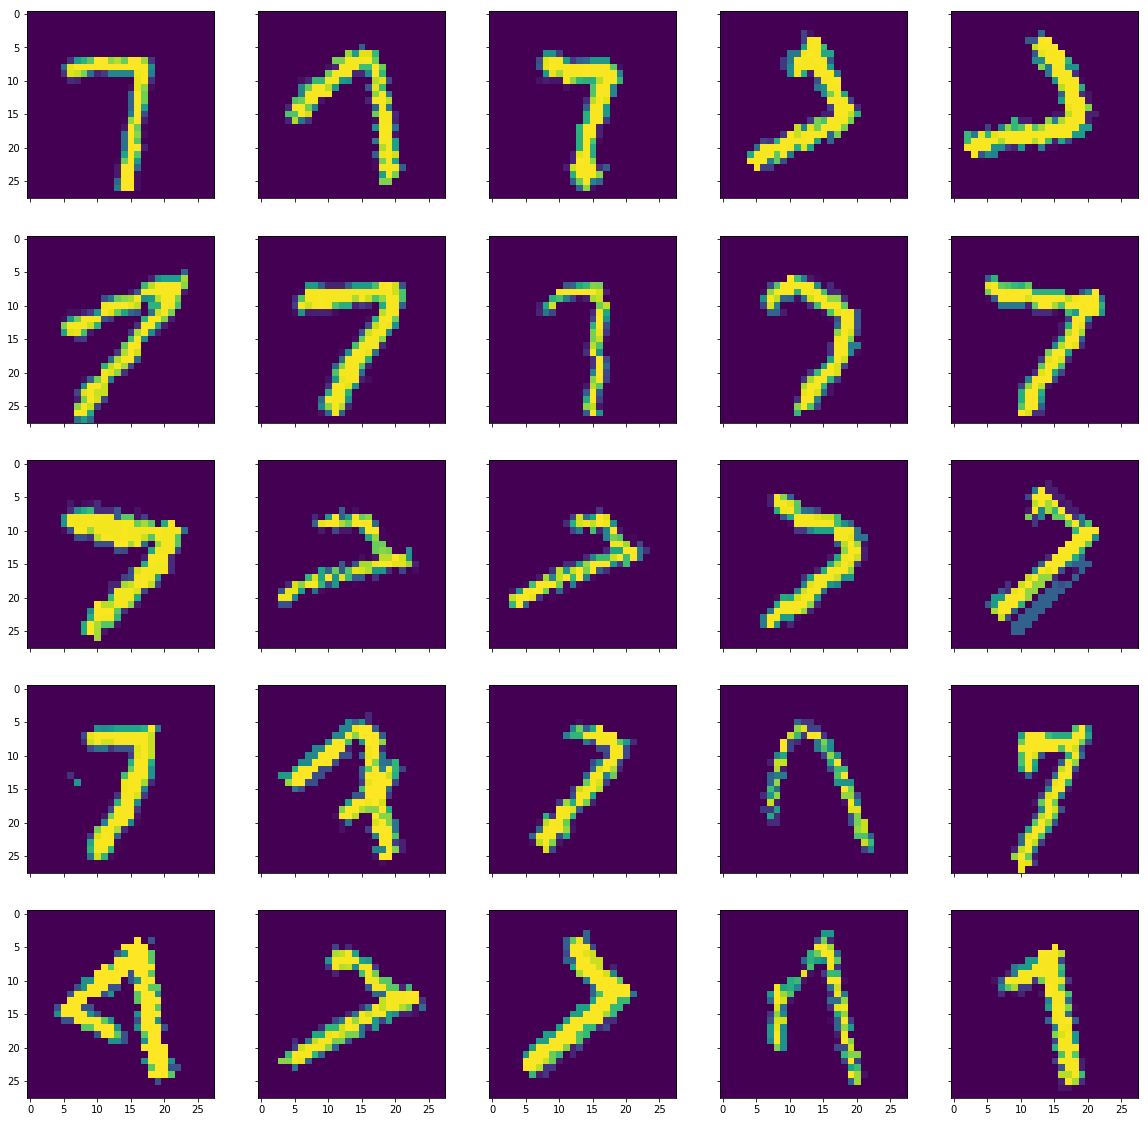

In [3]:
# Looking at first 25 training images
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex='all', sharey='all', figsize = (20,20))
i = 0
#=============================================================================================
# https://stackoverflow.com/questions/31726643/how-do-i-get-multiple-subplots-in-matplotlib
for row in ax:
    for col in row:
        col.imshow(train_data[i])
        i += 1
#=============================================================================================

In [4]:
# Loading test files
with open('hw4_te7.pkl', 'rb') as file:
    test_data = pickle.load(file)

In [5]:
# Dimension of code vector
code_dim = 5

In [6]:
# Defining the function used by decoder for sampling datapoints
# https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + z_var * epsilon

In [7]:
# Defining the model
# Layers used in the encoder network
encoder_conv10 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')
encoder_conv11 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')
encoder_pool1 = MaxPooling2D((2,2), padding = 'same')
# encoder_drop1 = Dropout(0.5)
encoder_conv20 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')
encoder_conv21 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')
encoder_pool2 = MaxPooling2D((2,2), padding = 'same')
# encoder_drop2 = Dropout(0.5)
encoder_flat = Flatten()
# encoder_drop3 = Dropout(0.5)
encoder_mean = Dense(code_dim)
encoder_sigma = Dense(code_dim)

# Layers used in the decoder network
decoder_fc1 = Dense(3136)
# decoder_drop1 = Dropout(0.5)
decoder_reshape1 = Reshape((7,7,64))
# decoder_drop2 = Dropout(0.5)
decoder_tconv1 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal')
decoder_conv1 = Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu', kernel_initializer='he_normal')
# decoder_drop3 = Dropout(0.5)
decoder_tconv2 = Conv2DTranspose(32, (3,3), strides=(2,2), padding = 'same', activation='relu', kernel_initializer='he_normal')
decoder_conv2 = Conv2D(32, (3,3), strides=(1,1), padding='same', activation='relu', kernel_initializer='he_normal')
# decoder_drop4 = Dropout(0.5)
decoder_last_layer = Conv2D(1, (3,3), padding = 'same', activation='sigmoid')

# Encoder architecture
encoder_input = Input(shape = (28, 28, 1))
enc = encoder_conv10(encoder_input)
enc = encoder_conv11(enc)
enc = encoder_pool1(enc)
# enc = encoder_drop1(enc)
enc = encoder_conv20(enc)
enc = encoder_conv21(enc)
enc = encoder_pool2(enc)
# enc = encoder_drop2(enc)
enc = encoder_flat(enc)
# enc = encoder_drop3(enc)
enc_mean = encoder_mean(enc)
enc_sigma = encoder_sigma(enc)
encoder_output = Lambda(sampling)([enc_mean, enc_sigma])
encoder = Model(encoder_input, encoder_output)

# Decoder architecture
dec = decoder_fc1(encoder_output)
# dec = decoder_drop1(dec)
dec = decoder_reshape1(dec)
# dec = decoder_drop2(dec)
dec = decoder_tconv1(dec)
dec = decoder_conv1(dec)
# dec = decoder_drop3(dec)
dec = decoder_tconv2(dec)
dec = decoder_conv2(dec)
# dec = decoder_drop4(dec)
decoder_output = decoder_last_layer(dec)

# Taking the decoder/generator as seperate model
generator_input = Input(shape = (code_dim,))
gen = decoder_fc1(generator_input)
# gen = decoder_drop1(gen)
gen = decoder_reshape1(gen)
# gen = decoder_drop2(gen)
gen = decoder_tconv1(gen)
gen = decoder_conv1(gen)
# gen = decoder_drop3(gen)
gen = decoder_tconv2(gen)
gen = decoder_conv2(gen)
# gen = decoder_drop4(gen)
generator_output = decoder_last_layer(gen)
generator = Model(generator_input, generator_output)

# Variational AutoEncoder
vae = Model(encoder_input, decoder_output)

In [8]:
# Variational AutoEncoder
vae = Model(encoder_input, decoder_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [9]:
# Encoder
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [10]:
# Generator/Decoder
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              18816     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        9248      
__________

In [11]:
# Loss function used for training the network
def vae_loss(input_img, decoded_img):
    reconstruction_loss = binary_crossentropy(K.flatten(input_img), K.flatten(decoded_img))
    kl_loss = -0.001 * K.sum(1 + K.log(K.square(enc_sigma)) - K.square(enc_mean) - K.square(enc_sigma), axis=-1)
    return reconstruction_loss + kl_loss

In [12]:
# Compiling model
vae.compile(loss=vae_loss, optimizer=Adam(lr = 0.0001), metrics=['accuracy'])

In [13]:
# Callback used to stop training the model when there's no improvement
callback_list = [EarlyStopping(monitor = 'val_loss', patience=20, restore_best_weights=True),
                ModelCheckpoint(filepath='vae.h5', save_best_only=True, monitor='val_loss')]

In [14]:
# Training the model
history = vae.fit(train_data[..., None], train_data[..., None], batch_size=128, epochs=500, validation_split=0.2)#, callbacks=callback_list)

Train on 5012 samples, validate on 1253 samples
Epoch 1/500
5012/5012 [==============================] - 4s 829us/step - loss: 0.6535 - acc: 0.7952 - val_loss: 0.5379 - val_acc: 0.8331
Epoch 2/500
5012/5012 [==============================] - 1s 221us/step - loss: 0.4193 - acc: 0.8323 - val_loss: 0.3360 - val_acc: 0.8331
Epoch 3/500
5012/5012 [==============================] - 1s 221us/step - loss: 0.3102 - acc: 0.8323 - val_loss: 0.2887 - val_acc: 0.8331
Epoch 4/500
5012/5012 [==============================] - 1s 222us/step - loss: 0.2828 - acc: 0.8323 - val_loss: 0.2798 - val_acc: 0.8331
Epoch 5/500
5012/5012 [==============================] - 1s 221us/step - loss: 0.2659 - acc: 0.8323 - val_loss: 0.2467 - val_acc: 0.8331
Epoch 6/500
5012/5012 [==============================] - 1s 221us/step - loss: 0.2382 - acc: 0.8323 - val_loss: 0.2277 - val_acc: 0.8331
Epoch 7/500
5012/5012 [==============================] - 1s 221us/step - loss: 0.2306 - acc: 0.8321 - val_loss: 0.2231 - val_acc: 

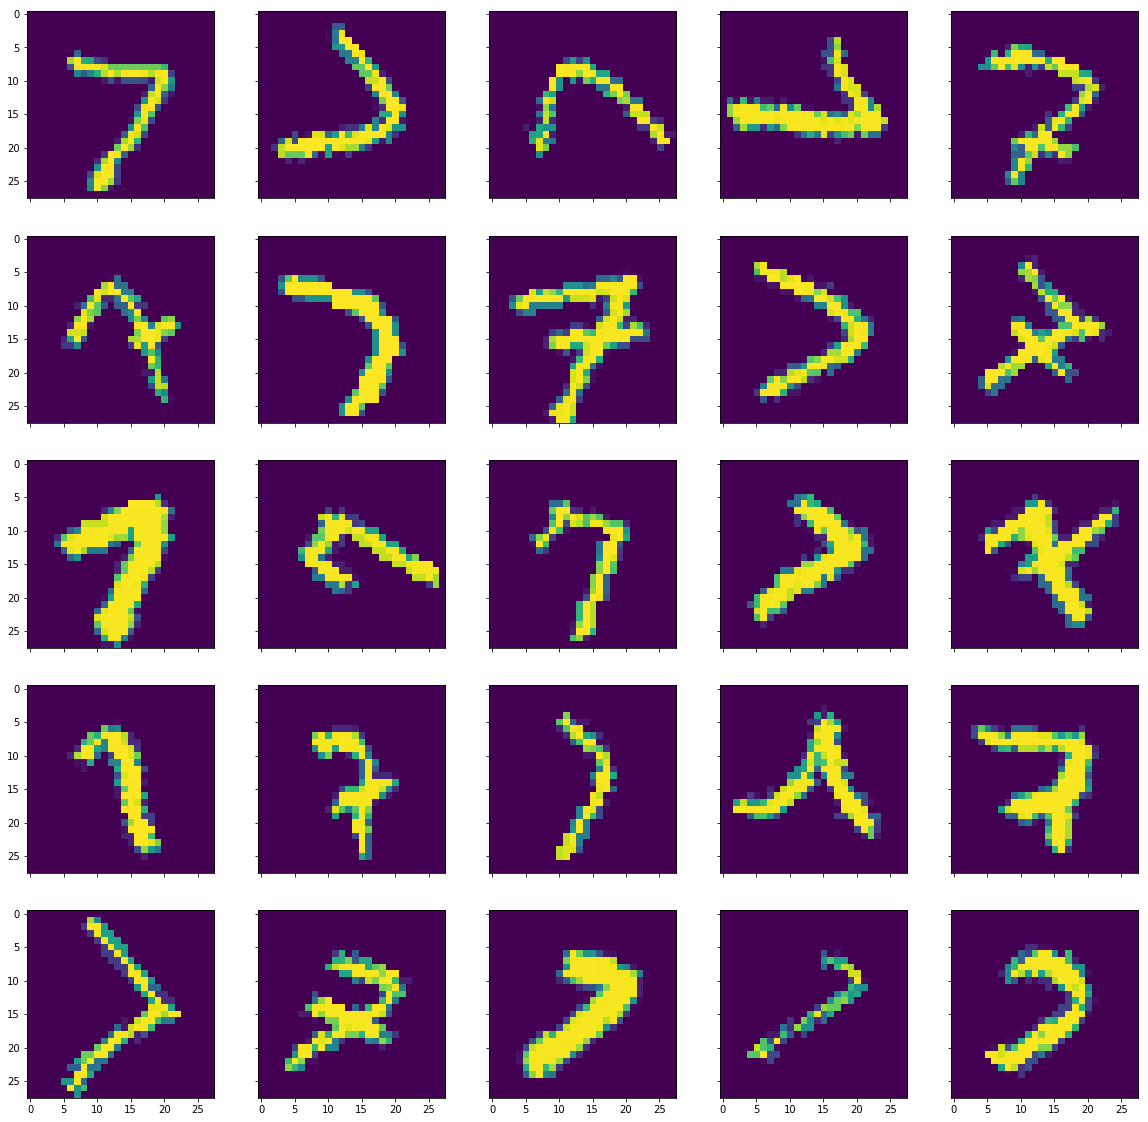

In [15]:
# Looking at first 25 test images
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex='all', sharey='all', figsize = (20,20))
i = 0
#=============================================================================================
# https://stackoverflow.com/questions/31726643/how-do-i-get-multiple-subplots-in-matplotlib
for row in ax:
    for col in row:
        col.imshow(test_data[i])
        i += 1
#=============================================================================================

In [16]:
# Obtaining reconstructions for held-out test data
pred = vae.predict(test_data[..., None])

In [17]:
# Reshaping predictions to make the dimenions of array suitable for display
pred = np.reshape(pred, (pred.shape[0], 28, 28))

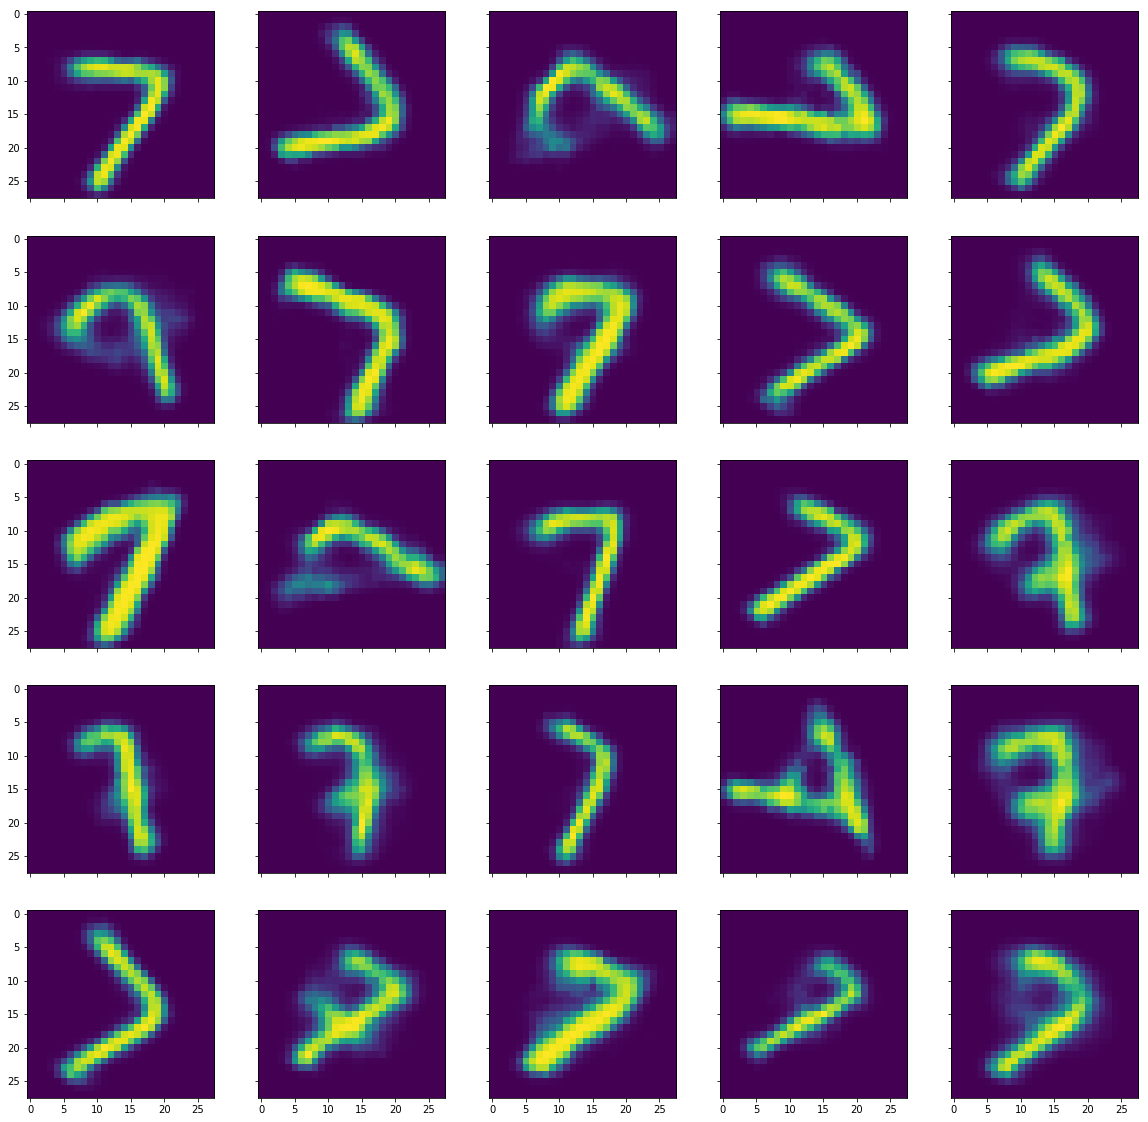

In [18]:
# Looking at first 25 reconstructed test images
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex='all', sharey='all', figsize = (20,20))
i = 0
#=============================================================================================
# https://stackoverflow.com/questions/31726643/how-do-i-get-multiple-subplots-in-matplotlib
for row in ax:
    for col in row:
        col.imshow(pred[i])
        i += 1
#=============================================================================================

In [36]:
# Generator that generates random code examples with code_dim-1 dimensions having same values in all the code vectors in batch
def generate_code(num_of_examples):
    for dim in range(code_dim):
        fixed = np.random.normal(size = (code_dim,))
        variable = np.random.normal(size = (num_of_examples,))
        variable.sort()
        code = np.tile(fixed[..., None], (num_of_examples,))
        code[dim] = variable
        yield code.T

In [37]:
# Getting the decoder/generator output for code vectors produced in last step
gen = generate_code(25)
output = []
for batch in gen:
    output.append(generator.predict_on_batch(batch))

In [38]:
# Reshaping obtained images to make them suitable for display
output = [np.squeeze(o) for o in output]

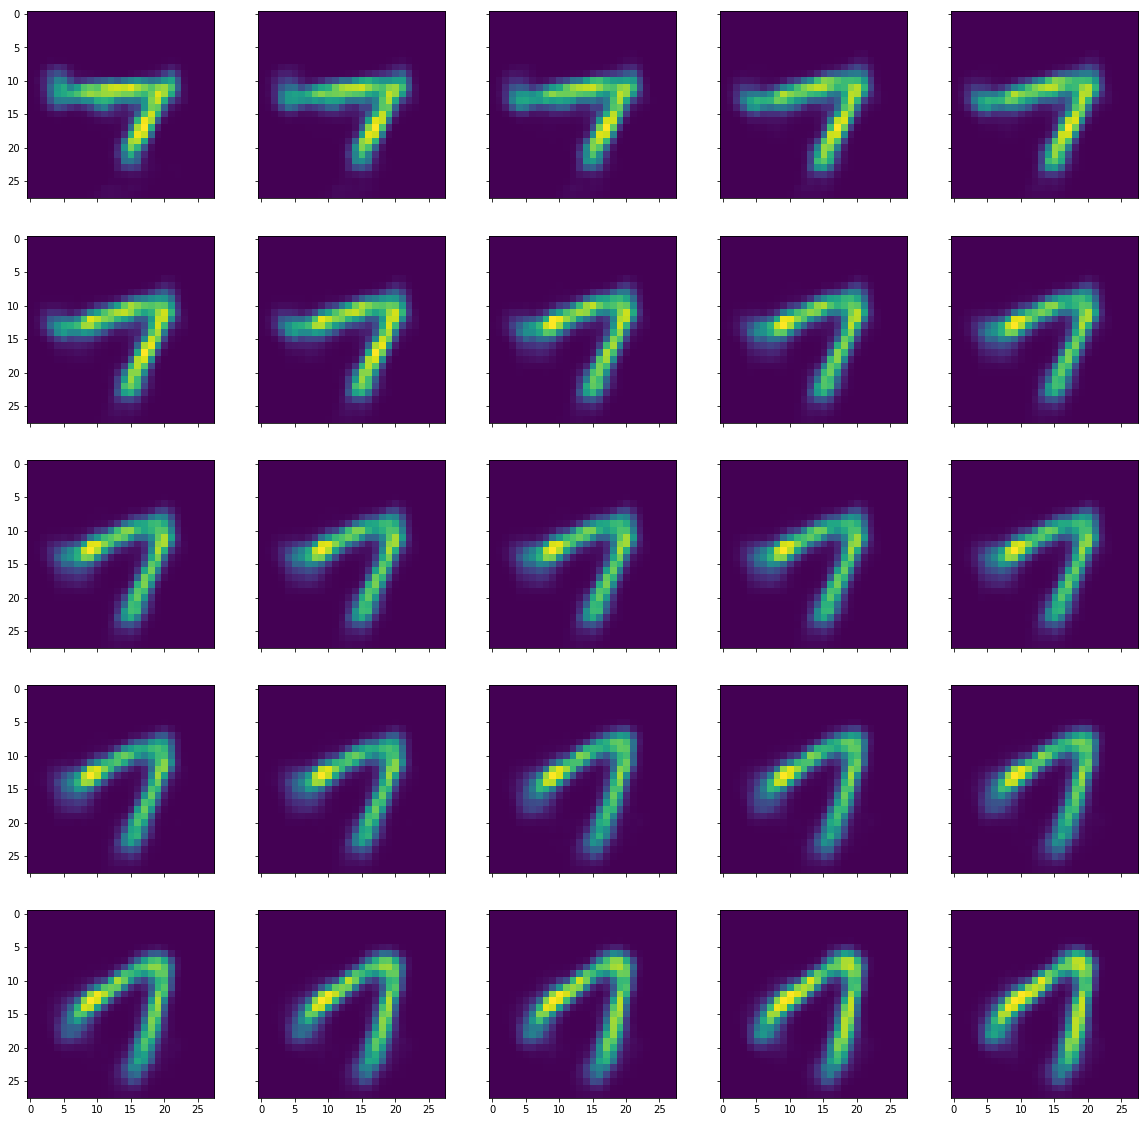

In [39]:
# Looking at 25 generated images varying first code dimension and keeping others fixed
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex='all', sharey='all', figsize = (20,20))
i = 0
j = 0
#=============================================================================================
# https://stackoverflow.com/questions/31726643/how-do-i-get-multiple-subplots-in-matplotlib
for row in ax:
    for col in row:
        col.imshow(output[i][j])
        j+=1
#=============================================================================================

Looking at these images, I believe, the first dimension captures the orientation of horizontal line of digit 7 as well as the length of vertical(slant) part. In each successive image, the horizontal part is getting closer to the vertical part and the length of vertical(slant) part seems to be increasing. I don't think this is the effect that Dr. Kim added to these images.

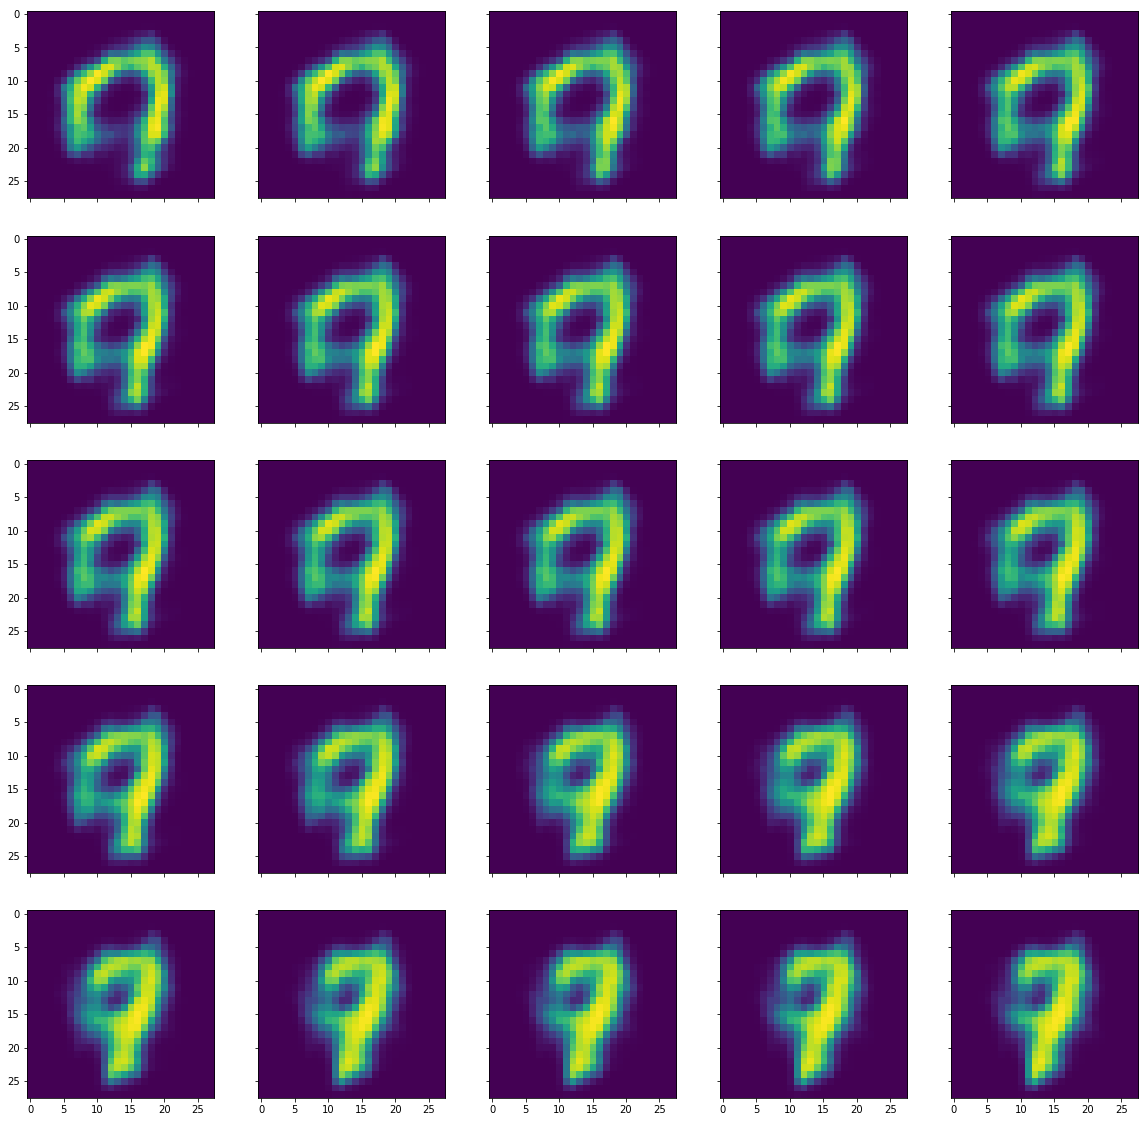

In [40]:
# Looking at 25 generated images varying second code dimension and keeping others fixed
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex='all', sharey='all', figsize = (20,20))
i = 1
j = 0
#=============================================================================================
# https://stackoverflow.com/questions/31726643/how-do-i-get-multiple-subplots-in-matplotlib
for row in ax:
    for col in row:
        col.imshow(output[i][j])
        j+=1
#=============================================================================================

This is the most unique effect that I see in the generated images. By varying the second dimension, A shaped (or slightly 9 like) 7's are getting transformed to a proper 7 with a horizontal stoke in the middle. I strongly believe that this is the effect added by Dr. Kim.

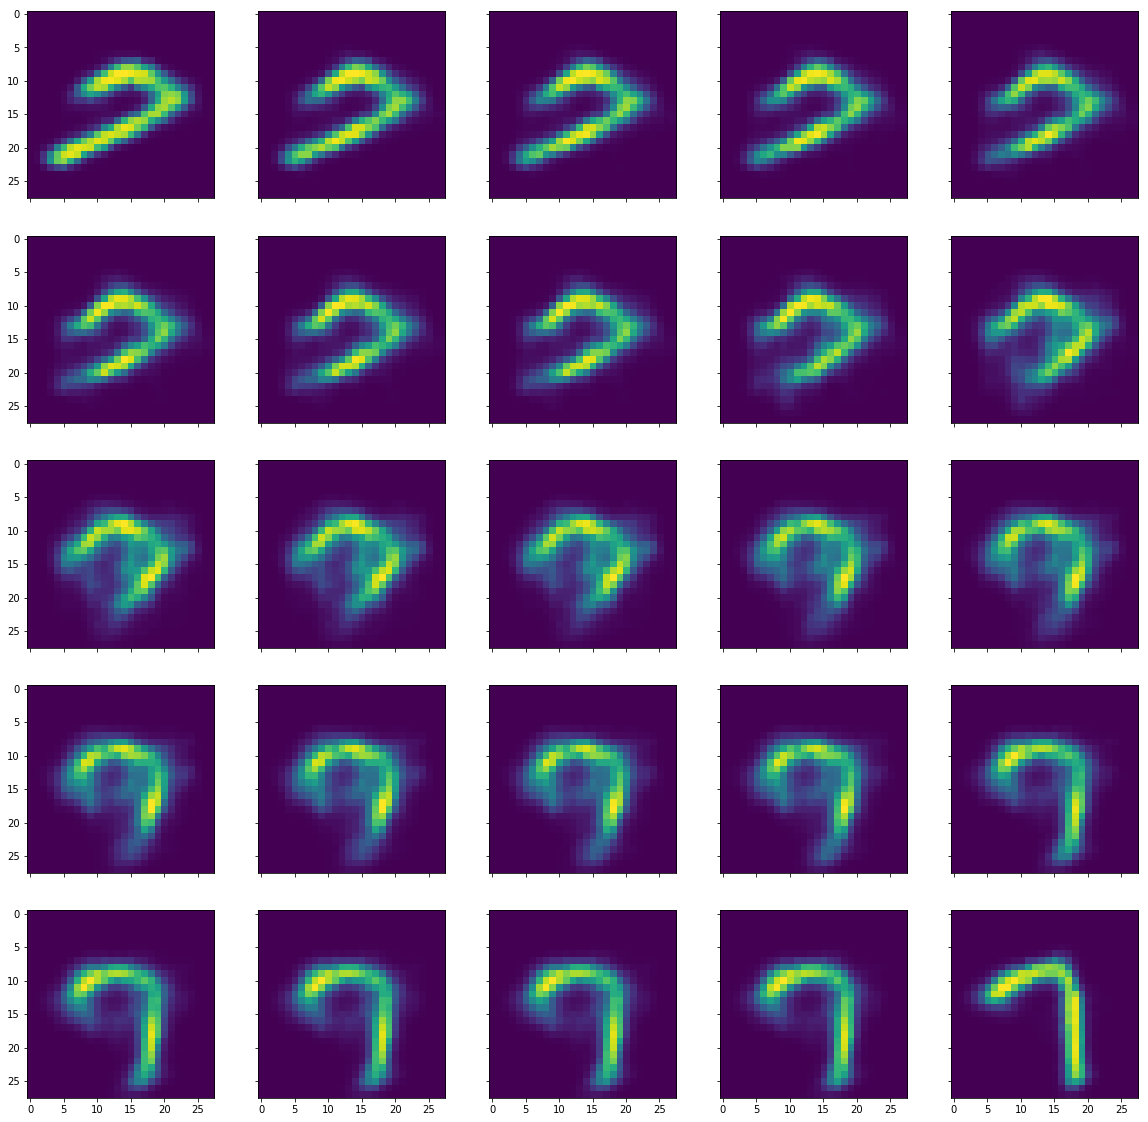

In [41]:
# Looking at 25 generated images varying third code dimension and keeping others fixed
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex='all', sharey='all', figsize = (20,20))
i = 2
j = 0
#=============================================================================================
# https://stackoverflow.com/questions/31726643/how-do-i-get-multiple-subplots-in-matplotlib
for row in ax:
    for col in row:
        col.imshow(output[i][j])
        j+=1
#=============================================================================================

The effect of varying the third dimension is kind of unique too. In the beginning we see falling 7's which are then getting transformed to round, smooth 7's and finally we get cane like 7's. I was really confused between this effect and the effect produced by varying second dimension as the special effect added by Dr. Kim but the previous transformations seem more unique so I decided to go with that.

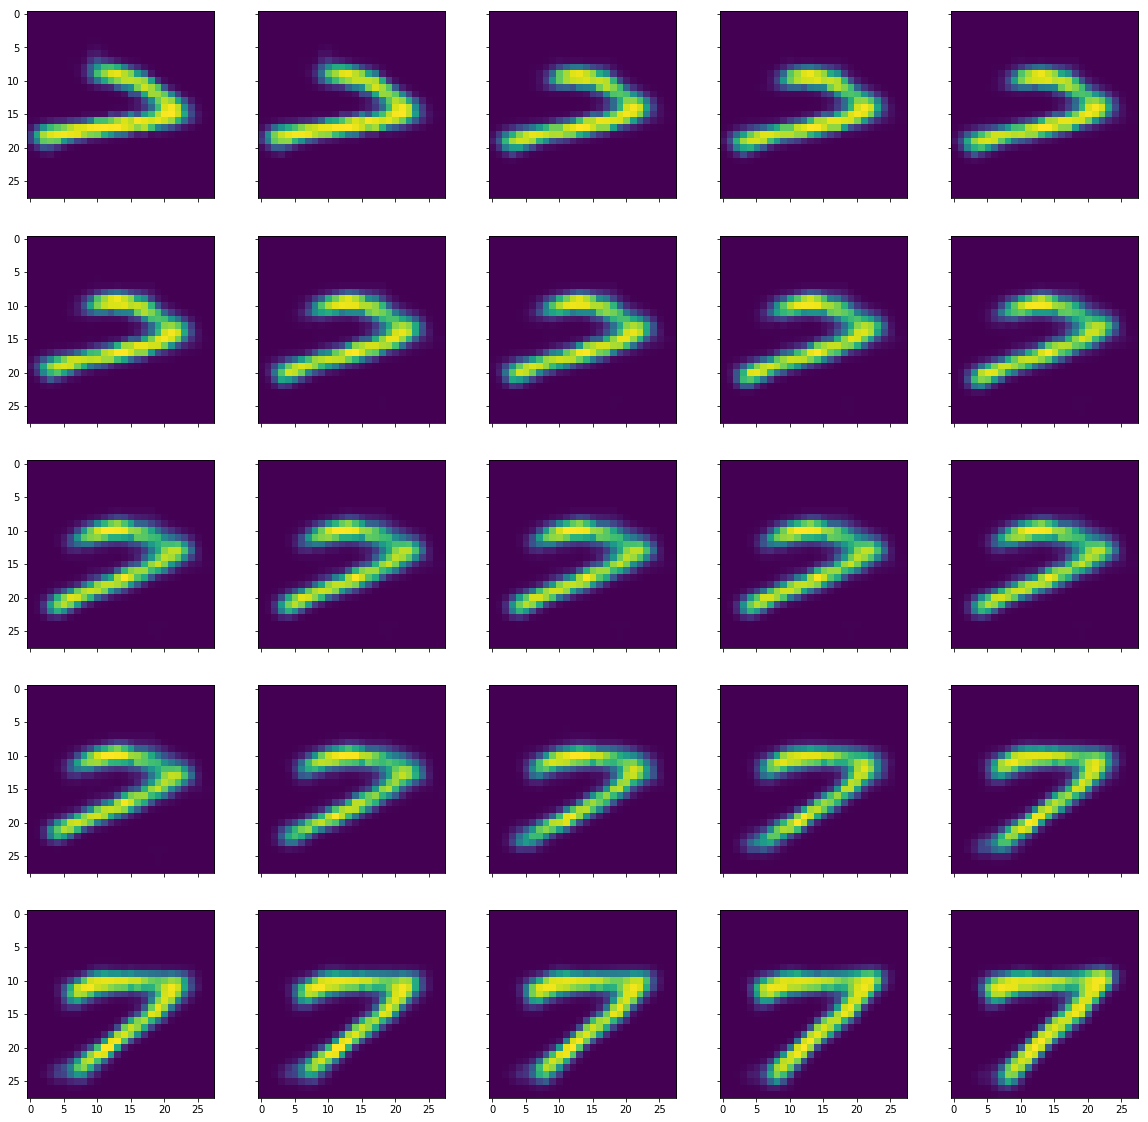

In [42]:
# Looking at 25 generated images varying fourth code dimension and keeping others fixed
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex='all', sharey='all', figsize = (20,20))
i = 3
j = 0
#=============================================================================================
# https://stackoverflow.com/questions/31726643/how-do-i-get-multiple-subplots-in-matplotlib
for row in ax:
    for col in row:
        col.imshow(output[i][j])
        j+=1
#=============================================================================================

I think this dimension controls the general orientation and thickness of 7's. In each successive image, we see the 7's getting thicker and rotated slightly anti-clockwise.

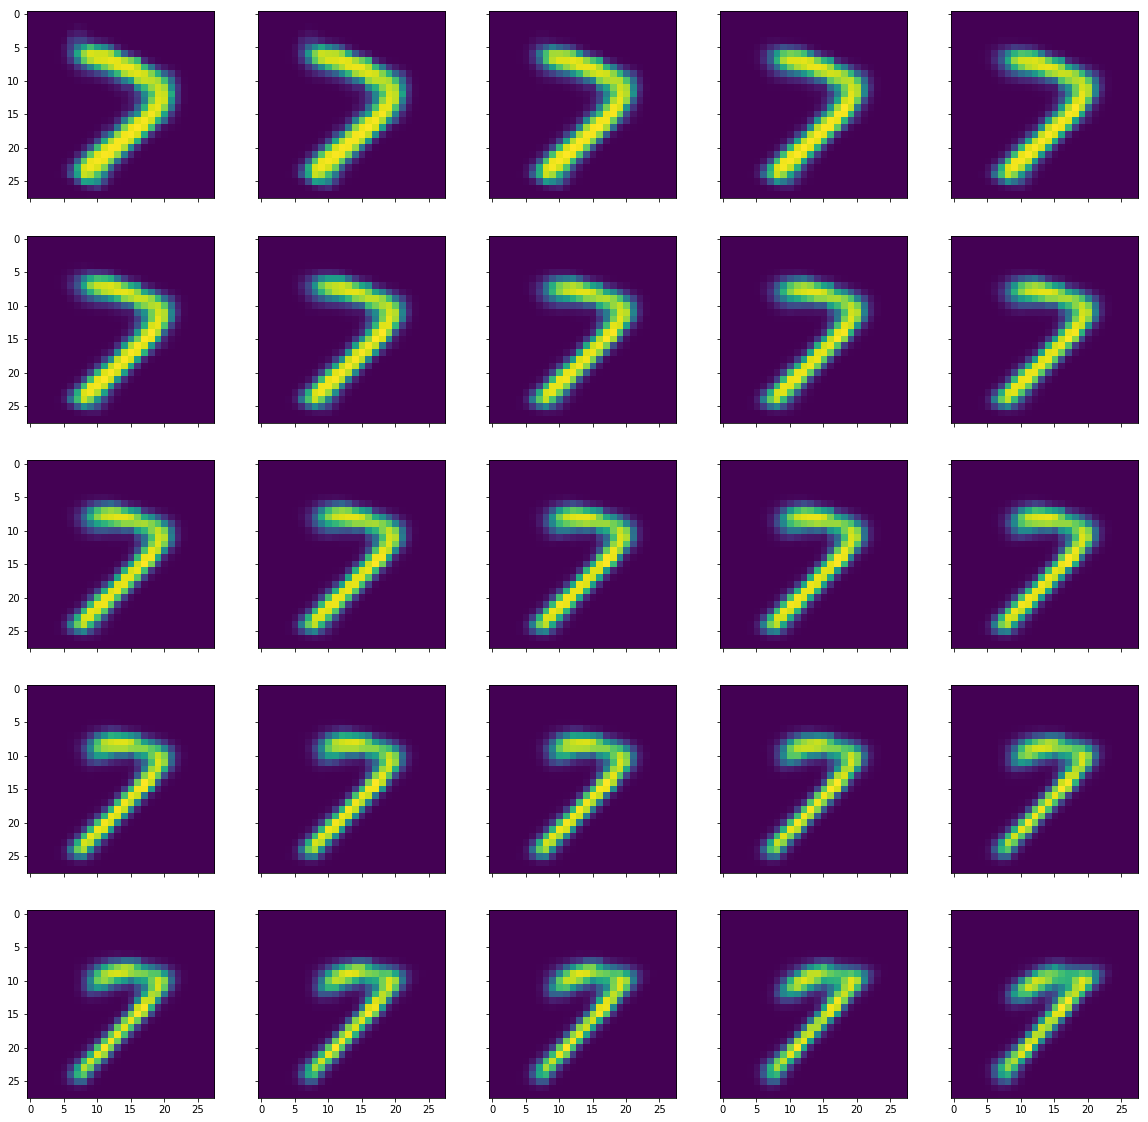

In [43]:
# Looking at 25 generated images varying last code dimension and keeping others fixed
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex='all', sharey='all', figsize = (20,20))
i = 4
j = 0
#=============================================================================================
# https://stackoverflow.com/questions/31726643/how-do-i-get-multiple-subplots-in-matplotlib
for row in ax:
    for col in row:
        col.imshow(output[i][j])
        j+=1
#=============================================================================================

I think the last code dimension is capturing the thickness of digit and shape of horizontal part of 7's as well as its orientation with respect to the slant (vertical) part.  From what looks like a greater than sign (>) in the beginning we get a nice looking 7 in the end. Similarily, the digits get thinner and more well-defined as we move towards the end. Also, the shape of horizontal bar changes from a line to 'L'-shaped as we move towards the end.